In [1]:
import importlib
from libs import models, plots, trades, params
importlib.reload(models)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(trades)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime

from tqdm import tqdm
import matplotlib.pyplot as plt   
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayDataset])


In [2]:
device               = params.device
ticker               = params.ticker
base_path            = params.save_path
label_col            = params.label_col
feature_cols         = params.feature_cols
pred_threshold       = params.pred_threshold_man
regular_start        = params.regular_start
regular_start_pred   = params.regular_start_pred
regular_start_shifted= params.regular_start_shifted
regular_end          = params.regular_end
trailing_stop_thresh = params.trailing_stop_thresh_man

# month to inspect (YYYY-MM)
date_to_check = params.date_to_check

# model path
val_rmse_str = "0.2012"   # same rmse in the filename

csv_dir: str = "./dfs training"
path_csv = f"{csv_dir}/{ticker}_test_DF.csv"

model_path = base_path / f"{ticker}_{val_rmse_str}.pth"
model_path

PosixPath('dfs training/GOOGL_0.2012.pth')

In [3]:
# Load the entire model object (architecture + weights)
model_best = torch.load(model_path, map_location=device, weights_only=False)
model_best.to(device).eval()
model_best

DualMemoryLSTM(
  (short_lstm): LSTM(5, 64, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (do_short): Dropout(p=0.3, inplace=False)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(64, 128, batch_first=True)
  (do_long): Dropout(p=0.4, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
dataset_test_path = base_path / f"{ticker}_test_ds.pt"
dataset_test = torch.load(dataset_test_path)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

dataset_val_path = base_path / f"{ticker}_val_ds.pt"
dataset_val = torch.load(dataset_val_path)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

dataloader_test, dataloader_val

(<torch.utils.data.dataloader.DataLoader at 0x7a67ca6a8200>,
 <torch.utils.data.dataloader.DataLoader at 0x7a67ca403ce0>)

In [5]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(dataloader_val)
test_baseline = models.naive_rmse(dataloader_test)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.42690
Test zero‐forecast baseline RMSE = 0.40524


std val: 0.25449163
std test: 0.24845211


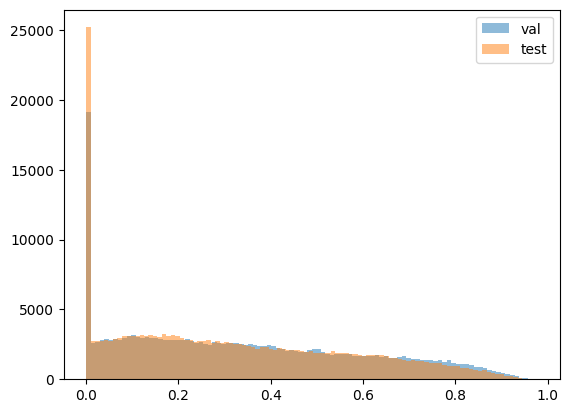

In [6]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in dataloader_val])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in dataloader_test])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [7]:

def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str = "Test",
    compute_rmse: bool = True,
    collect_preds: bool = False
):
    """
    Run your LSTM over every day in `loader`, with the same reset logic
    you use in rmse_over_windows and collect_predictions, but controlled by flags:
      - compute_rmse: if True, accumulates MSE and returns RMSE
      - collect_preds: if True, gathers every window's prediction into a flat array

    Returns:
      (rmse, preds) where:
        • rmse is a float if compute_rmse else None
        • preds is a 1D np.ndarray if collect_preds else None

    You can call:
      rmse, _     = evaluate_model(model, loader, device, split_name, True, False)
      _, preds    = evaluate_model(model, loader, device, split_name, False, True)
      rmse, preds = evaluate_model(model, loader, device, split_name, True, True)
    """
    # Move model & reset its internal state
    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_wd        = None
    total_sq_error = 0.0     # for RMSE
    total_windows  = 0       # counter for windows
    all_preds      = []      # list to store per-day preds

    # Iterate exactly as in two original functions
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", unit="day"):
            # Unpack: xb_day, yb_day, optional raw_*, wd
            xb_day, yb_day, *_, wd = batch
            wd_val = int(wd.item())

            # reset per-day LSTM
            model.reset_short()
            # reset per-week LSTM on weekday wrap
            if prev_wd is not None and wd_val < prev_wd:
                model.reset_long()
            prev_wd = wd_val

            # pull input windows and true targets
            x    = xb_day[0].to(device)        # shape: (W, look_back, F)
            y    = yb_day.view(-1).to(device)  # shape: (W,)

            # forward pass → get last-step prediction
            out  = model(x)                    # (W, look_back, 1)
            pred = out[:, -1, 0]               # (W,)

            # accumulate RMSE stats if requested
            if compute_rmse:
                total_sq_error += (pred - y).pow(2).sum().item()
                total_windows  += y.numel()

            # collect raw preds if requested
            if collect_preds:
                all_preds.append(pred.cpu().numpy())

    # compute final RMSE
    rmse = None
    if compute_rmse:
        rmse = math.sqrt(total_sq_error / total_windows)
        print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")

    # flatten collected predictions
    preds = None
    if collect_preds:
        preds = np.concatenate(all_preds, axis=0)

    return rmse, preds


In [8]:
val_rmse, _     = evaluate_model(model_best, dataloader_val, device, split_name="Validation")
test_rmse, _     = evaluate_model(model_best, dataloader_test, device, split_name="Test")

_, preds = evaluate_model(model_best, dataloader_test, device,
                          split_name="Test",
                          compute_rmse=False, collect_preds=True)

preds.shape

Validation: 100%|██████████| 410/410 [00:02<00:00, 141.54day/s]



Validation RMSE over 209510 windows = 0.20123


Test: 100%|██████████| 422/422 [00:02<00:00, 149.80day/s]



Test RMSE over 215642 windows = 0.21928


Test: 100%|██████████| 422/422 [00:02<00:00, 141.88day/s]


(215642,)

In [9]:
df = pd.read_csv(path_csv, index_col=0, parse_dates=True)
df.sort_index(inplace=True)
df

open      high      low     close     volume  \
2023-10-12 10:30:00  141.150  141.1500  141.150  141.1500       19.0   
2023-10-12 10:31:00  141.150  141.1500  141.150  141.1500        2.0   
2023-10-12 10:32:00  141.130  141.1300  141.130  141.1300       15.0   
2023-10-12 10:33:00  141.150  141.1500  141.150  141.1500      401.0   
2023-10-12 10:34:00  141.155  141.1550  141.155  141.1550      201.5   
...                      ...       ...      ...       ...        ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650   621199.0   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800   624198.0   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100   454542.0   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  1094746.0   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  7649838.0   

                          bid       ask  StrategyEarning  EarningDiff  \
2023-10-12 10:30:00  141.1077  141.1923              0.0        0.000   
2023-10-12 10:31:00  141.1077  141.1923              0.0        0.000   
2023-10-12 10:32:00  141.0877  141.1723              0.0        0.000   
2023-10-12 10:33:00  141.1077  141.1923              0.0        0.000   
2023-10-12 10:34:00  141.1127  141.1973              0.0        0.000   
...                       ...       ...              ...          ...   
2025-06-18 20:56:00  173.5129  173.6171             -1.4        1.310   
2025-06-18 20:57:00  173.3280  173.4320             -1.4        1.495   
2025-06-18 20:58:00  173.2580  173.3620             -1.4        1.565   
2025-06-18 20:59:00  173.2280  173.3320             -1.4        1.595   
2025-06-18 21:00:00  173.5576  173.6618             -1.4        1.265   

                     signal_scaled  signal_smooth  signal_action  pred_signal  \
2023-10-12 10:30:00       0.487668       0.493230              0          NaN   
2023-10-12 10:31:00       0.489133       0.492058              0          NaN   
2023-10-12 10:32:00       0.508124       0.491430              0          NaN   
2023-10-12 10:33:00       0.492077       0.491142              0          NaN   
2023-10-12 10:34:00       0.489149       0.487116              0          NaN   
...                            ...            ...            ...          ...   
2025-06-18 20:56:00       0.000000       0.000000              0     0.061808   
2025-06-18 20:57:00       0.000000       0.000000              0     0.011339   
2025-06-18 20:58:00       0.000000       0.000000              0    -0.014253   
2025-06-18 20:59:00       0.000000       0.000000              0    -0.021916   
2025-06-18 21:00:00       0.000000       0.000000              0    -0.068604   

                     pred_action  
2023-10-12 10:30:00            0  
2023-10-12 10:31:00            0  
2023-10-12 10:32:00            0  
2023-10-12 10:33:00            0  
2023-10-12 10:34:00            0  
...                          ...  
2025-06-18 20:56:00            0  
2025-06-18 20:57:00            0  
2025-06-18 20:58:00            0  
2025-06-18 20:59:00            0  
2025-06-18 21:00:00            0  

[266282 rows x 14 columns]

In [10]:
def add_pred_actions(
    df, preds
) -> pd.DataFrame:
    """
    1) Load full‐period minute‐bar DF.
    2) Stamp preds only on the exact rows the model saw:
         – drop all bars before regular_start_shifted of each day
         – then keep only times inside [regular_start_pred, regular_end)
    3) Run generate_trade_actions on each calendar‐day slice.
    4) Reassemble, persist, and return.
    """

    df["pred_signal"] = np.nan

    # 1) reconstruct all days → drop bars before regular_start_shifted per day
    valid_ts = []
    for _, day_df in df.groupby(df.index.normalize(), sort=False):
        day_df = day_df.sort_index()

        # truncate everything before the shifted start time
        truncated = day_df.loc[day_df.index.time >= regular_start_shifted]

        # 2) define from when to start the prediction (to get the predicted signal even before the regular start)
        mask = (truncated.index.time >= regular_start_pred)
        valid_ts.append(truncated.index[mask])

    valid_idx = pd.DatetimeIndex(
        np.concatenate([ts.values for ts in valid_ts])
    )

    if len(valid_idx) != len(preds):
        raise ValueError(
            f"{len(valid_idx)} valid slots vs {len(preds)} preds"
        )

    # 3) stamp predictions into the minute‐bar DF
    df.loc[valid_idx, "pred_signal"] = preds

    # 4) generate trade actions _per day_ only from regular_start
    dfs = []
    for day, day_df in df.groupby(df.index.normalize(), sort=False):
        dfs.append(
            trades.generate_trade_actions(
                df                   = day_df,
                col_signal           = "pred_signal",
                col_action           = "pred_action",
                buy_threshold        = pred_threshold,
                trailing_stop_thresh = trailing_stop_thresh,
                regular_start        = regular_start
            )
        )

    df_out = pd.concat(dfs).sort_index()
    df_out.to_csv(path_csv)
    return df_out


In [11]:
df_with_preds = add_pred_actions(df, preds)
df_with_preds

open      high      low     close     volume  \
2023-10-12 10:30:00  141.150  141.1500  141.150  141.1500       19.0   
2023-10-12 10:31:00  141.150  141.1500  141.150  141.1500        2.0   
2023-10-12 10:32:00  141.130  141.1300  141.130  141.1300       15.0   
2023-10-12 10:33:00  141.150  141.1500  141.150  141.1500      401.0   
2023-10-12 10:34:00  141.155  141.1550  141.155  141.1550      201.5   
...                      ...       ...      ...       ...        ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650   621199.0   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800   624198.0   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100   454542.0   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  1094746.0   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  7649838.0   

                          bid       ask  StrategyEarning  EarningDiff  \
2023-10-12 10:30:00  141.1077  141.1923              0.0        0.000   
2023-10-12 10:31:00  141.1077  141.1923              0.0        0.000   
2023-10-12 10:32:00  141.0877  141.1723              0.0        0.000   
2023-10-12 10:33:00  141.1077  141.1923              0.0        0.000   
2023-10-12 10:34:00  141.1127  141.1973              0.0        0.000   
...                       ...       ...              ...          ...   
2025-06-18 20:56:00  173.5129  173.6171             -1.4        1.310   
2025-06-18 20:57:00  173.3280  173.4320             -1.4        1.495   
2025-06-18 20:58:00  173.2580  173.3620             -1.4        1.565   
2025-06-18 20:59:00  173.2280  173.3320             -1.4        1.595   
2025-06-18 21:00:00  173.5576  173.6618             -1.4        1.265   

                     signal_scaled  signal_smooth  signal_action  pred_signal  \
2023-10-12 10:30:00       0.487668       0.493230              0          NaN   
2023-10-12 10:31:00       0.489133       0.492058              0          NaN   
2023-10-12 10:32:00       0.508124       0.491430              0          NaN   
2023-10-12 10:33:00       0.492077       0.491142              0          NaN   
2023-10-12 10:34:00       0.489149       0.487116              0          NaN   
...                            ...            ...            ...          ...   
2025-06-18 20:56:00       0.000000       0.000000              0     0.061808   
2025-06-18 20:57:00       0.000000       0.000000              0     0.011339   
2025-06-18 20:58:00       0.000000       0.000000              0    -0.014253   
2025-06-18 20:59:00       0.000000       0.000000              0    -0.021916   
2025-06-18 21:00:00       0.000000       0.000000              0    -0.068604   

                     pred_action  
2023-10-12 10:30:00            0  
2023-10-12 10:31:00            0  
2023-10-12 10:32:00            0  
2023-10-12 10:33:00            0  
2023-10-12 10:34:00            0  
...                          ...  
2025-06-18 20:56:00            0  
2025-06-18 20:57:00            0  
2025-06-18 20:58:00            0  
2025-06-18 20:59:00            0  
2025-06-18 21:00:00            0  

[266282 rows x 14 columns]

In [12]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_with_preds,              # full DF with pred_action
    col_action          = "pred_action",              # name of the discrete action column
    regular_start       = params.regular_start,       
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2023-11:


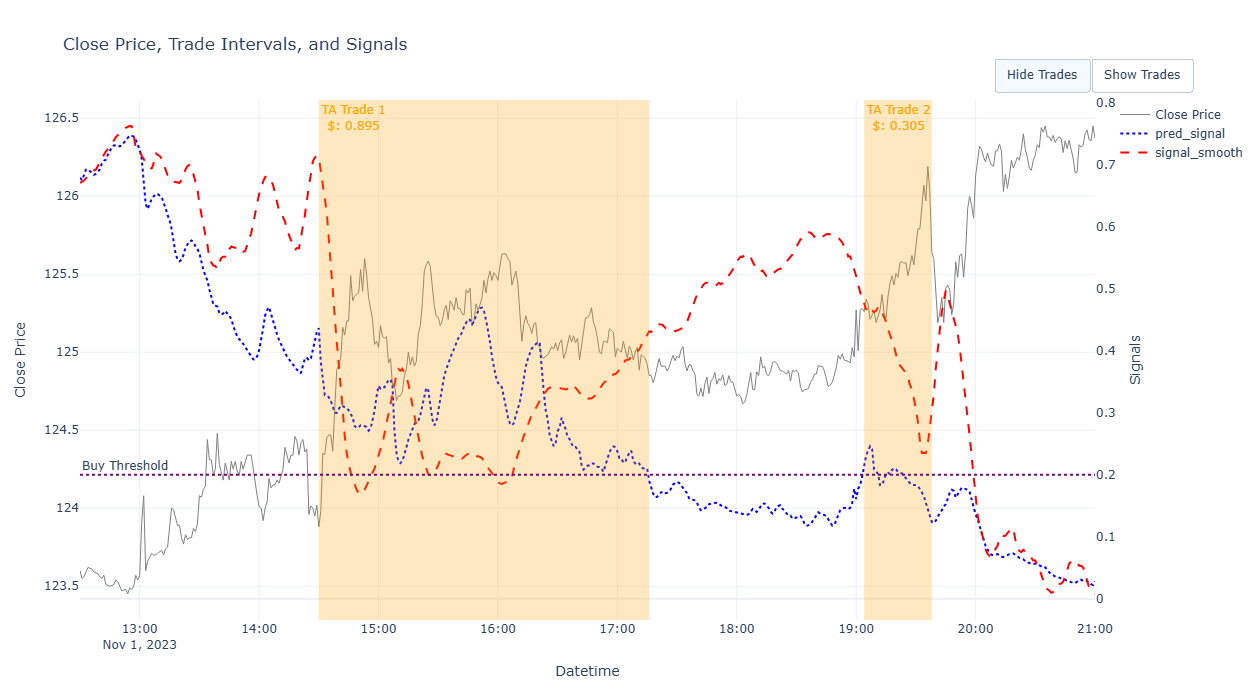


=== Performance for 2023-11-01 00:00:00 ===
Strategy Return ($): 1.2
Buy & Hold Return ($): 2.495
Trades Returns ($): [0.895, 0.305]


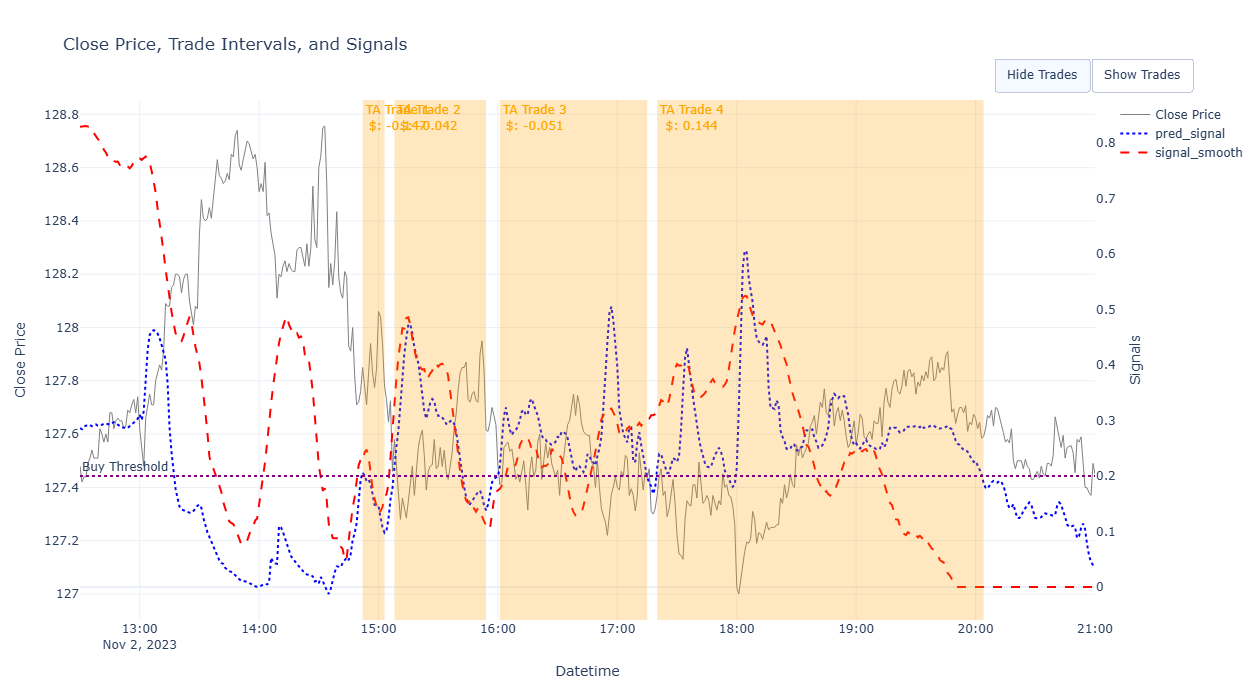


=== Performance for 2023-11-02 00:00:00 ===
Strategy Return ($): -0.096
Buy & Hold Return ($): -1.187
Trades Returns ($): [-0.147, -0.042, -0.051, 0.144]


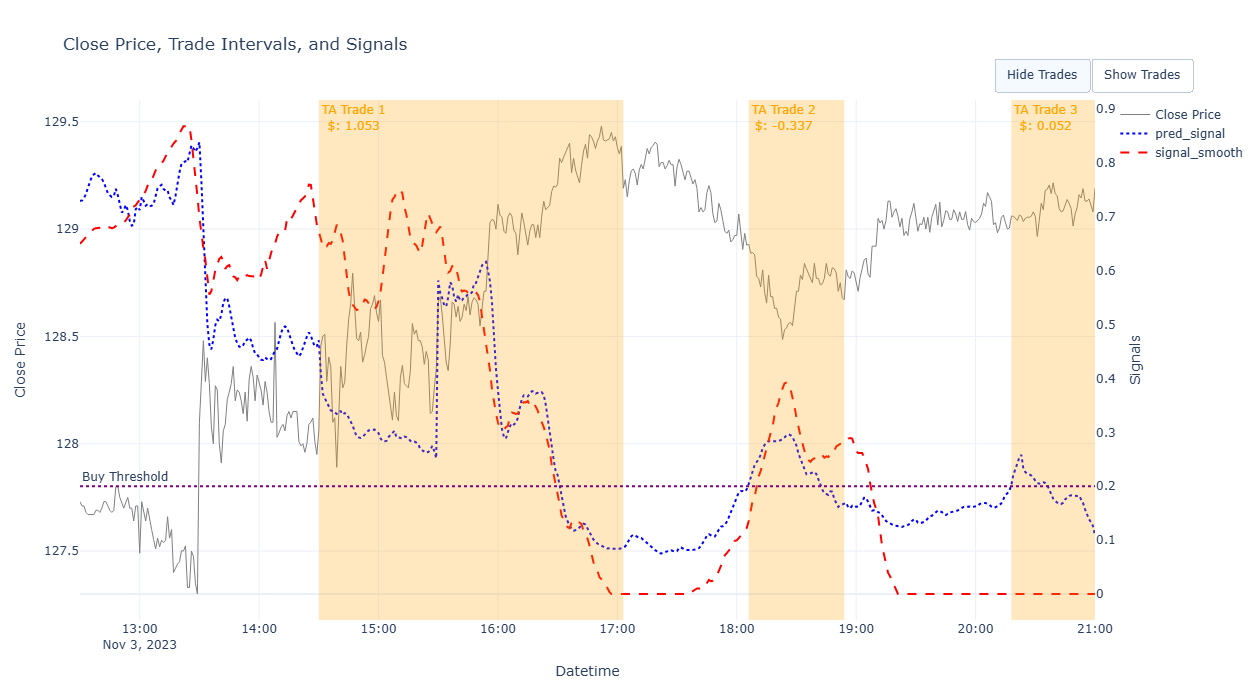


=== Performance for 2023-11-03 00:00:00 ===
Strategy Return ($): 0.658
Buy & Hold Return ($): 0.943
Trades Returns ($): [1.053, -0.337, 0.052]


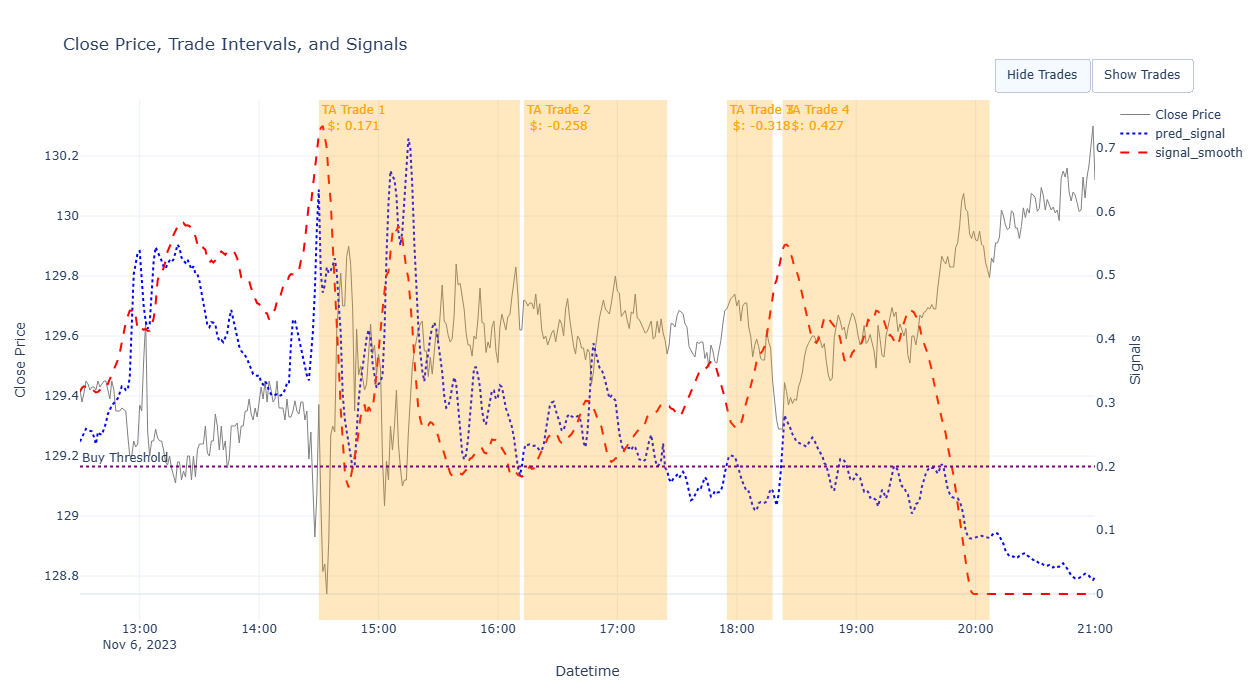


=== Performance for 2023-11-06 00:00:00 ===
Strategy Return ($): 0.023
Buy & Hold Return ($): 0.851
Trades Returns ($): [0.171, -0.258, -0.318, 0.427]


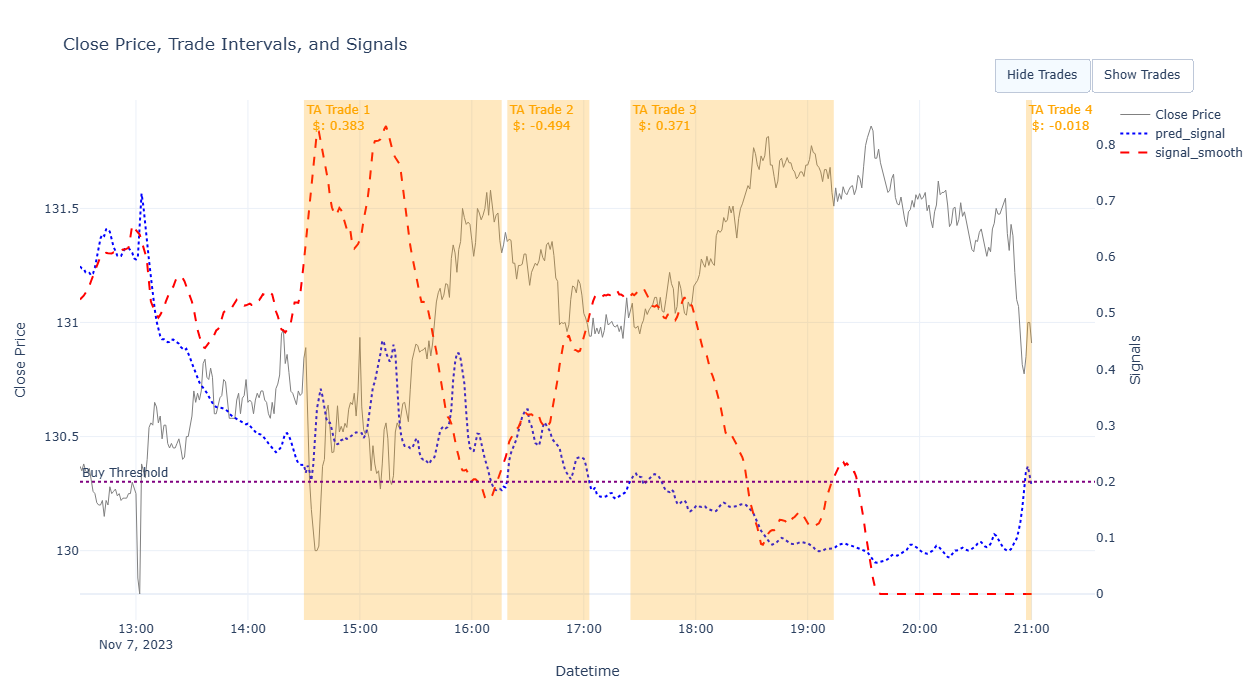


=== Performance for 2023-11-07 00:00:00 ===
Strategy Return ($): 0.332
Buy & Hold Return ($): 0.078
Trades Returns ($): [0.383, -0.494, 0.371, -0.018]


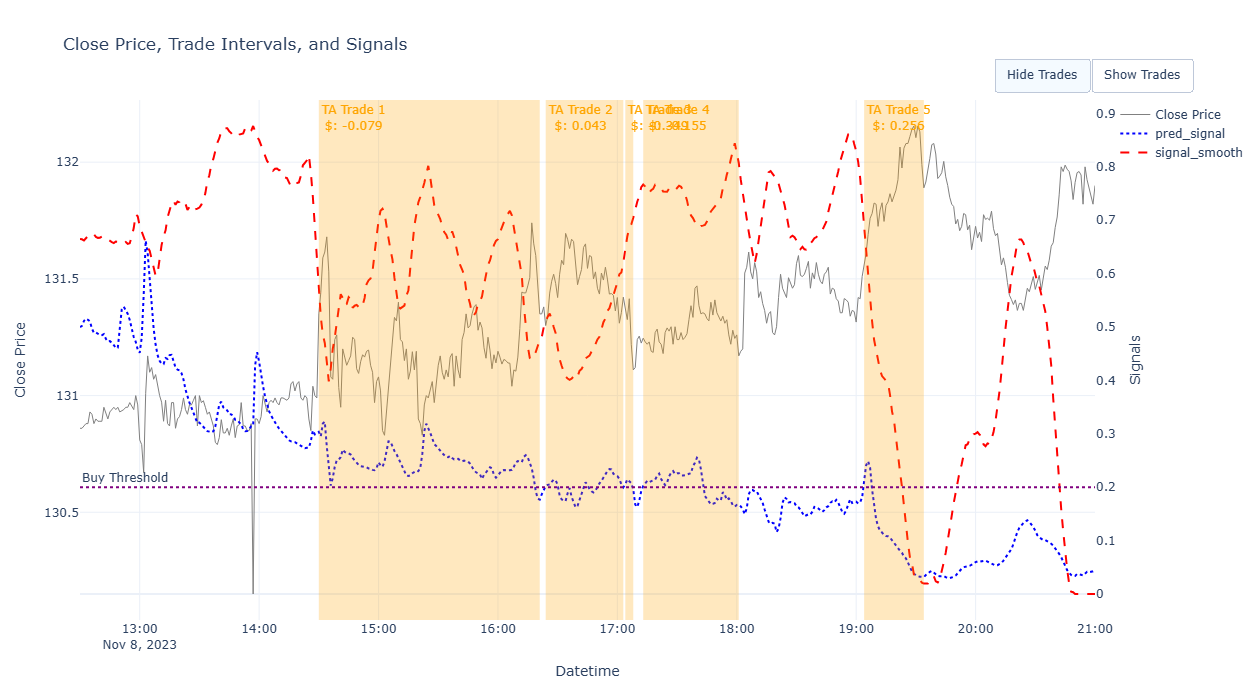


=== Performance for 2023-11-08 00:00:00 ===
Strategy Return ($): -0.284
Buy & Hold Return ($): 0.391
Trades Returns ($): [-0.079, 0.043, -0.349, -0.155, 0.256]


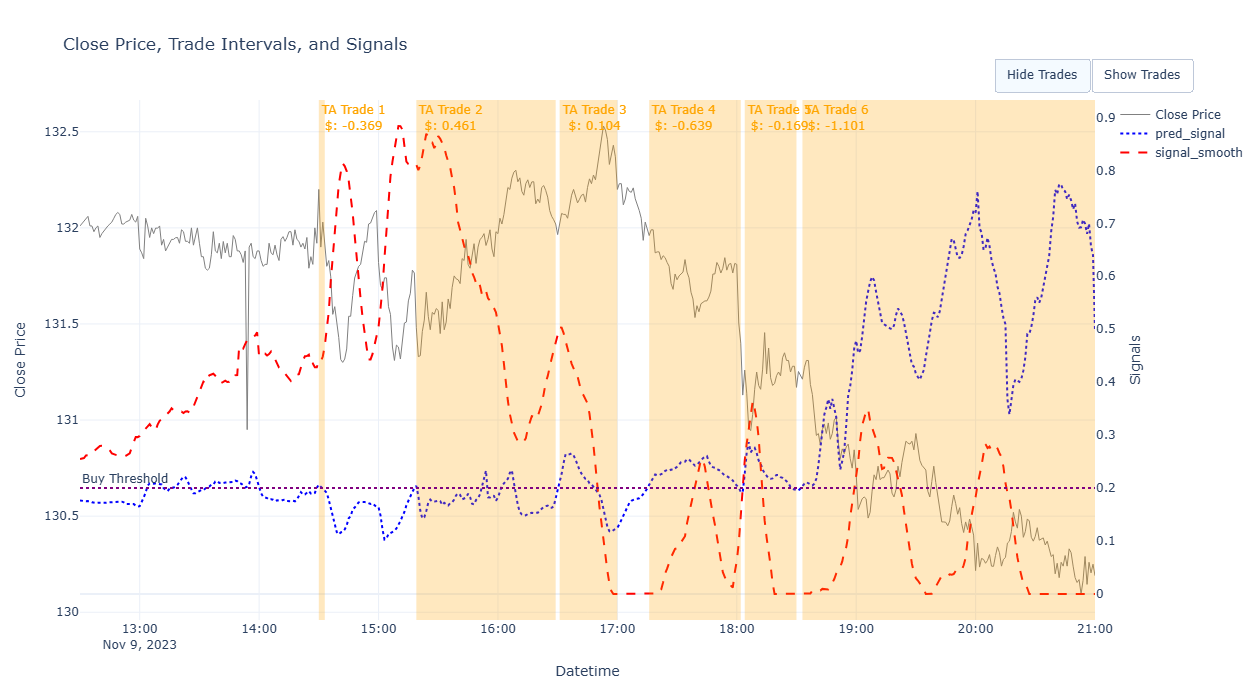


=== Performance for 2023-11-09 00:00:00 ===
Strategy Return ($): -1.653
Buy & Hold Return ($): -2.029
Trades Returns ($): [-0.369, 0.461, 0.104, -0.639, -0.169, -1.101]


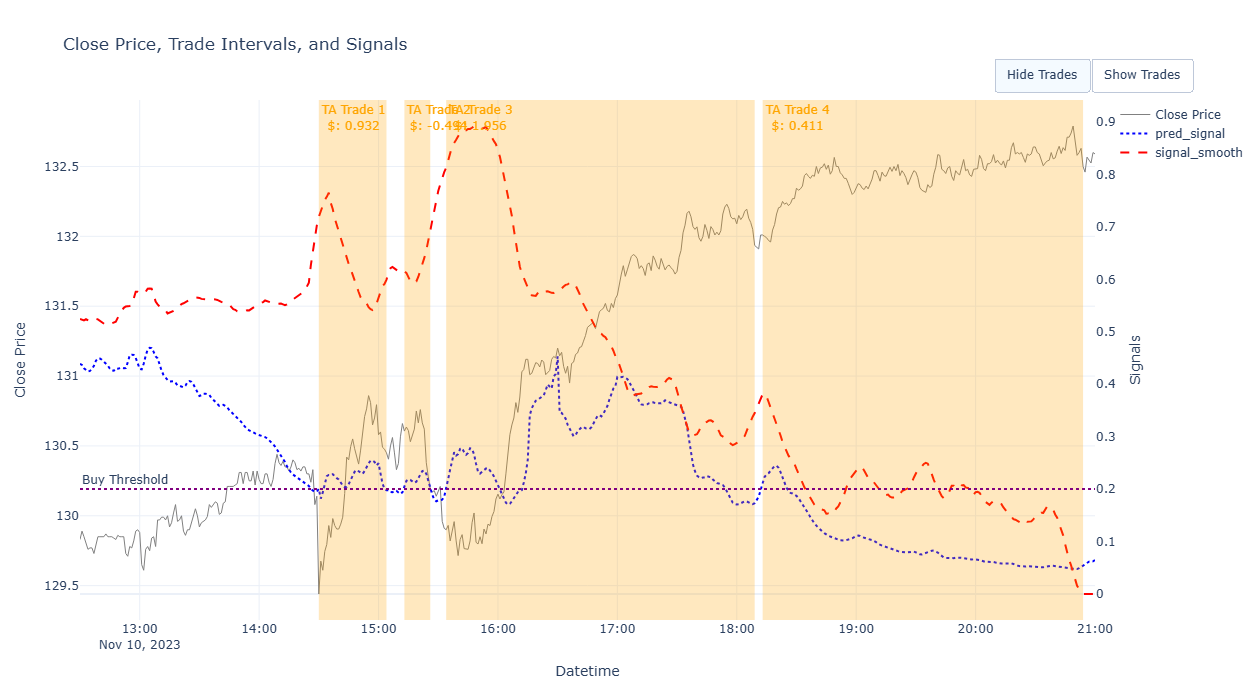


=== Performance for 2023-11-10 00:00:00 ===
Strategy Return ($): 2.805
Buy & Hold Return ($): 3.081
Trades Returns ($): [0.932, -0.494, 1.956, 0.411]


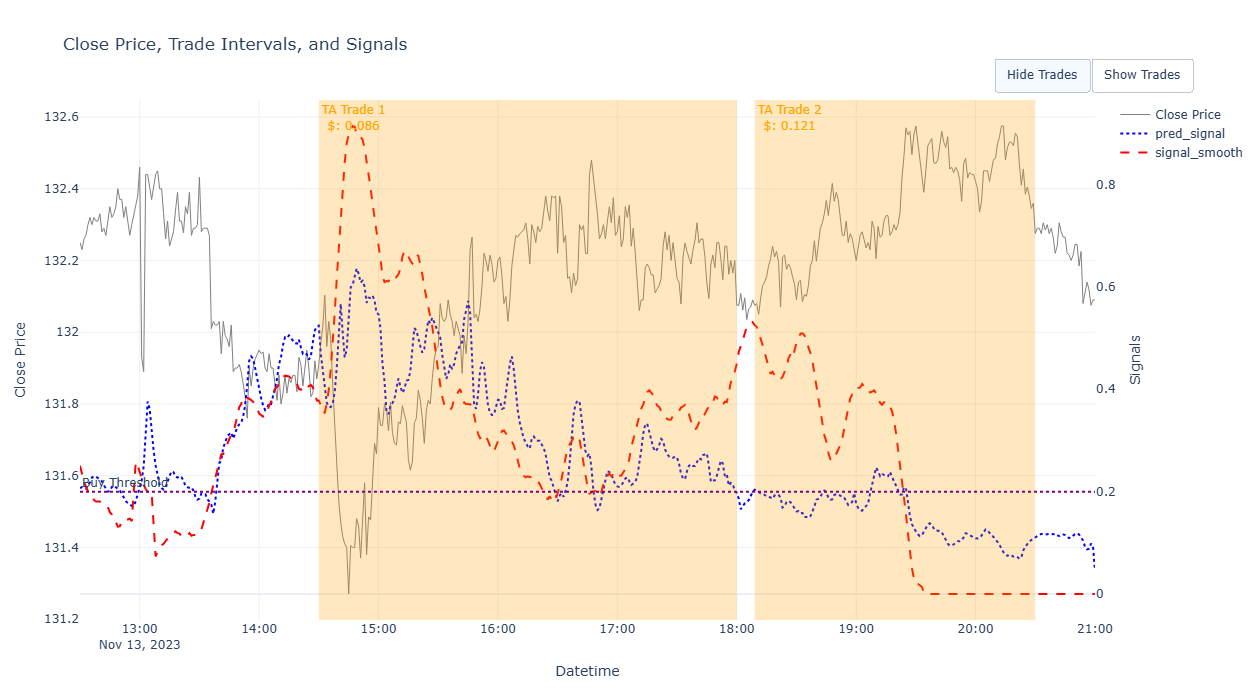


=== Performance for 2023-11-13 00:00:00 ===
Strategy Return ($): 0.207
Buy & Hold Return ($): 0.101
Trades Returns ($): [0.086, 0.121]


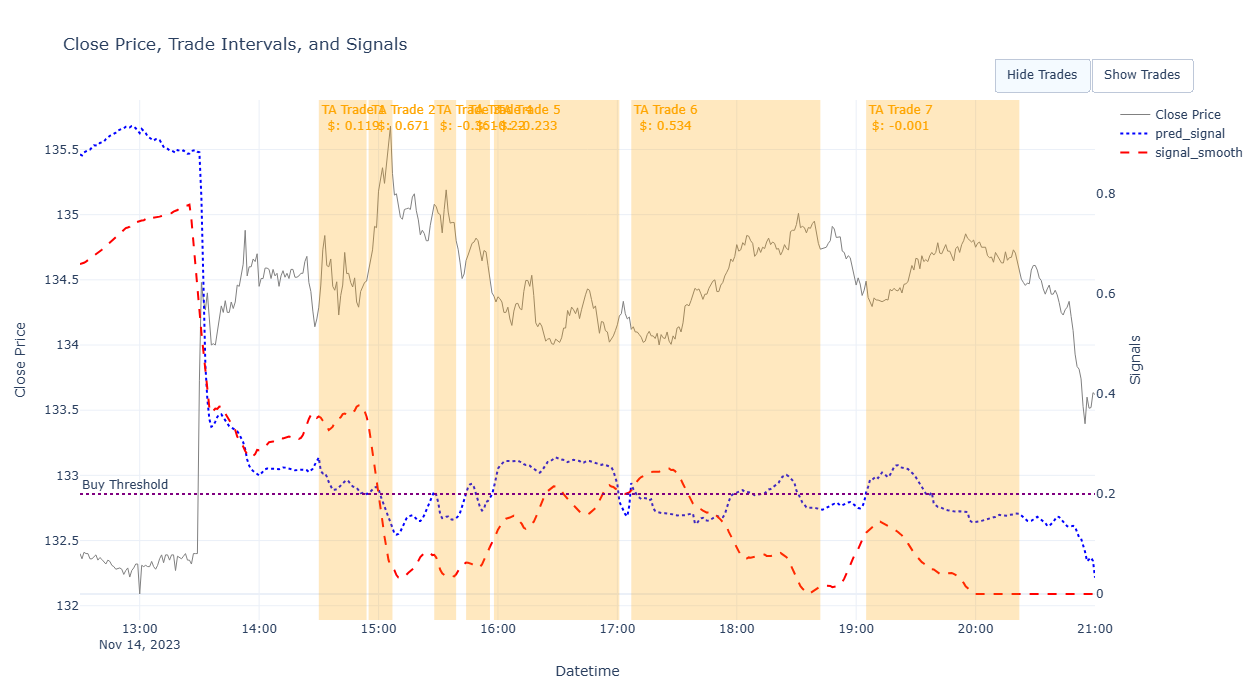


=== Performance for 2023-11-14 00:00:00 ===
Strategy Return ($): 0.51
Buy & Hold Return ($): -0.735
Trades Returns ($): [0.119, 0.671, -0.361, -0.22, -0.233, 0.534, -0.001]


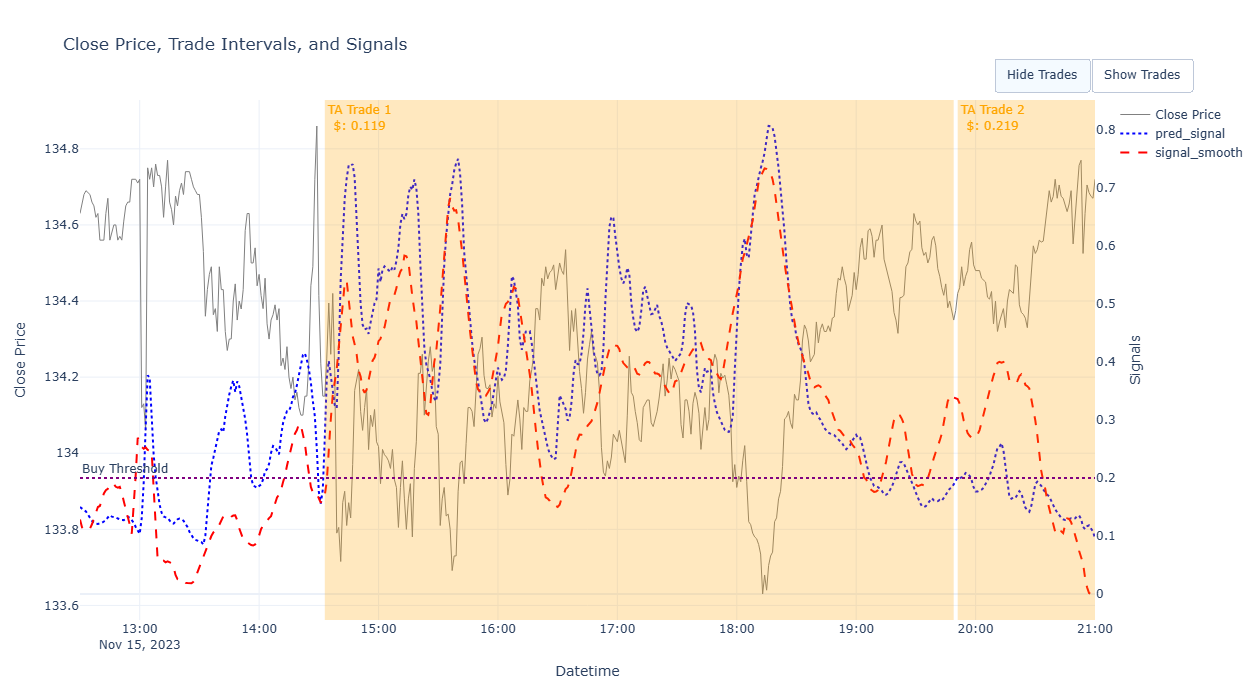


=== Performance for 2023-11-15 00:00:00 ===
Strategy Return ($): 0.289
Buy & Hold Return ($): 0.174
Trades Returns ($): [0.119, 0.219]


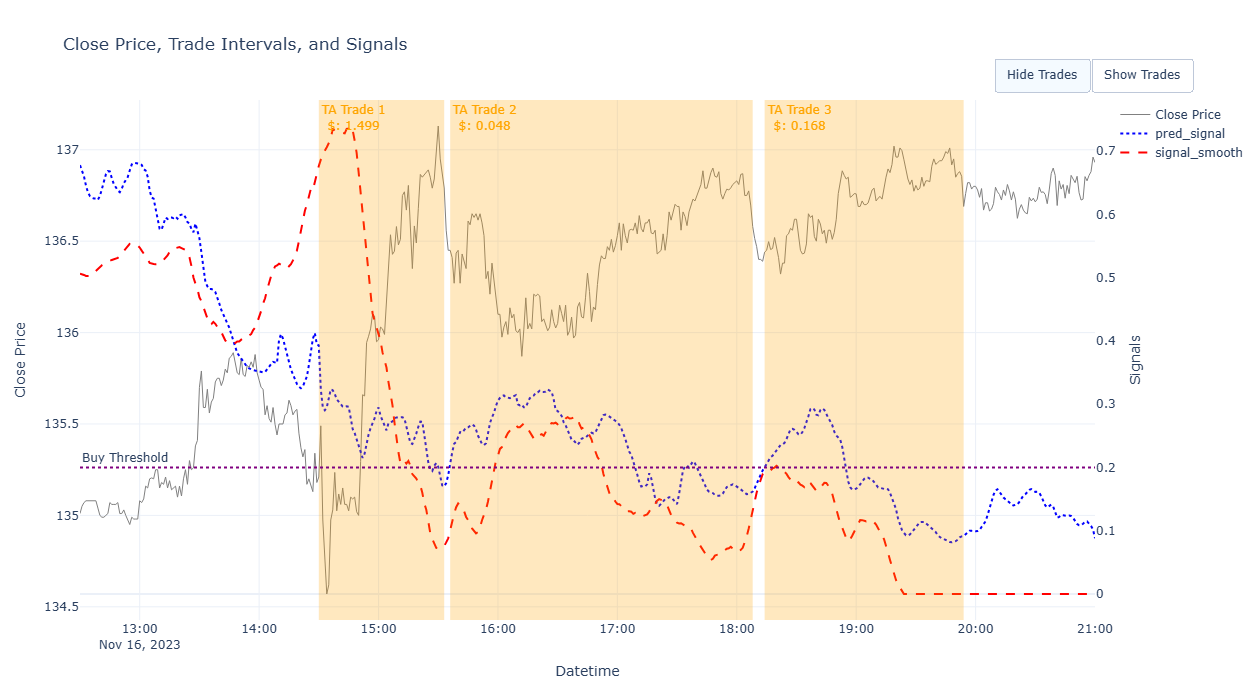


=== Performance for 2023-11-16 00:00:00 ===
Strategy Return ($): 1.716
Buy & Hold Return ($): 1.668
Trades Returns ($): [1.499, 0.048, 0.168]


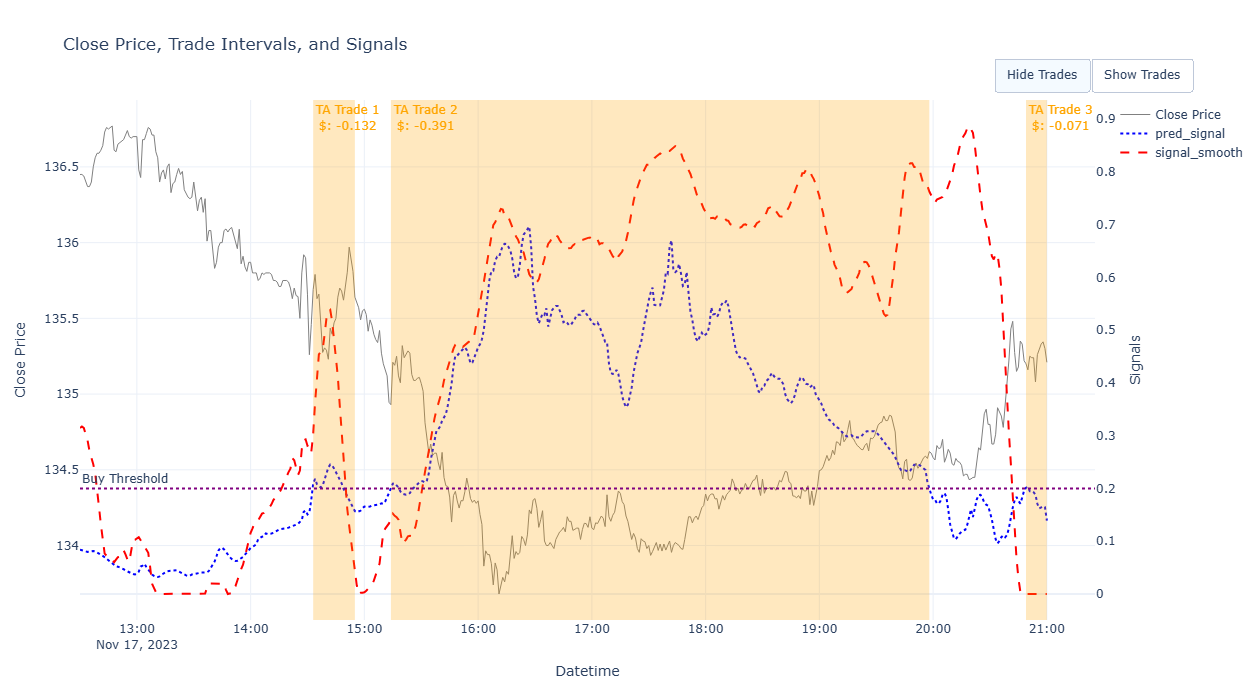


=== Performance for 2023-11-17 00:00:00 ===
Strategy Return ($): -0.504
Buy & Hold Return ($): -0.436
Trades Returns ($): [-0.132, -0.391, -0.071]


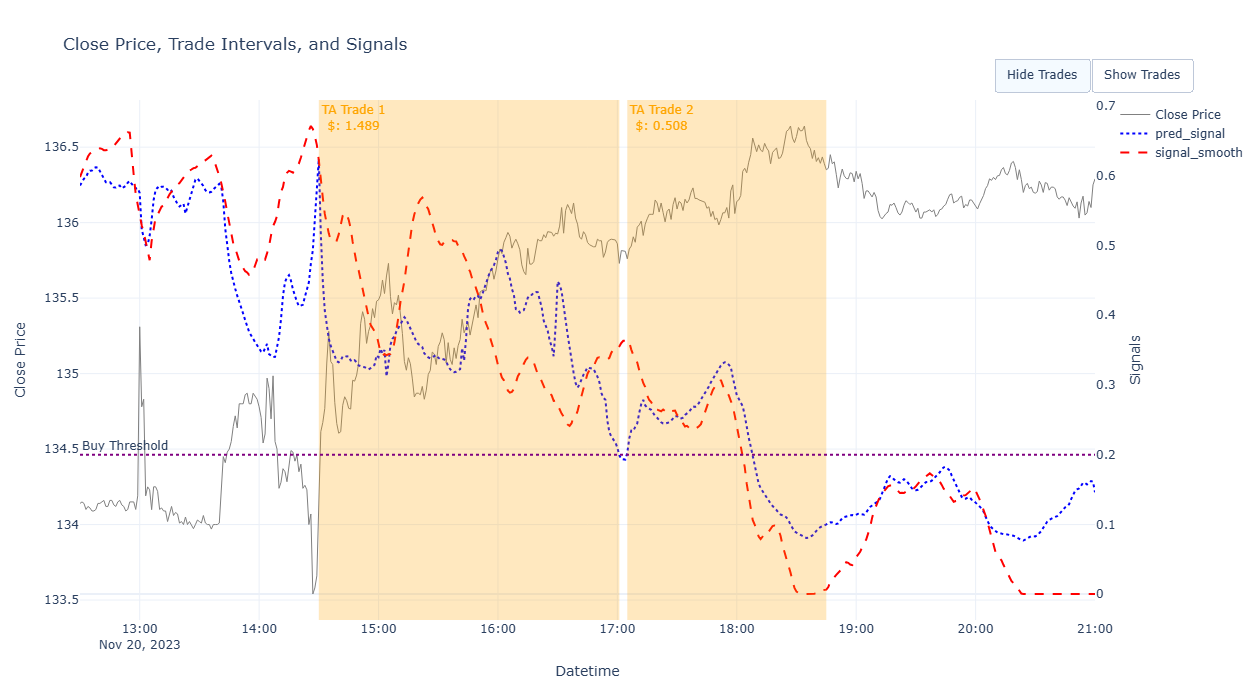


=== Performance for 2023-11-20 00:00:00 ===
Strategy Return ($): 1.998
Buy & Hold Return ($): 2.009
Trades Returns ($): [1.489, 0.508]


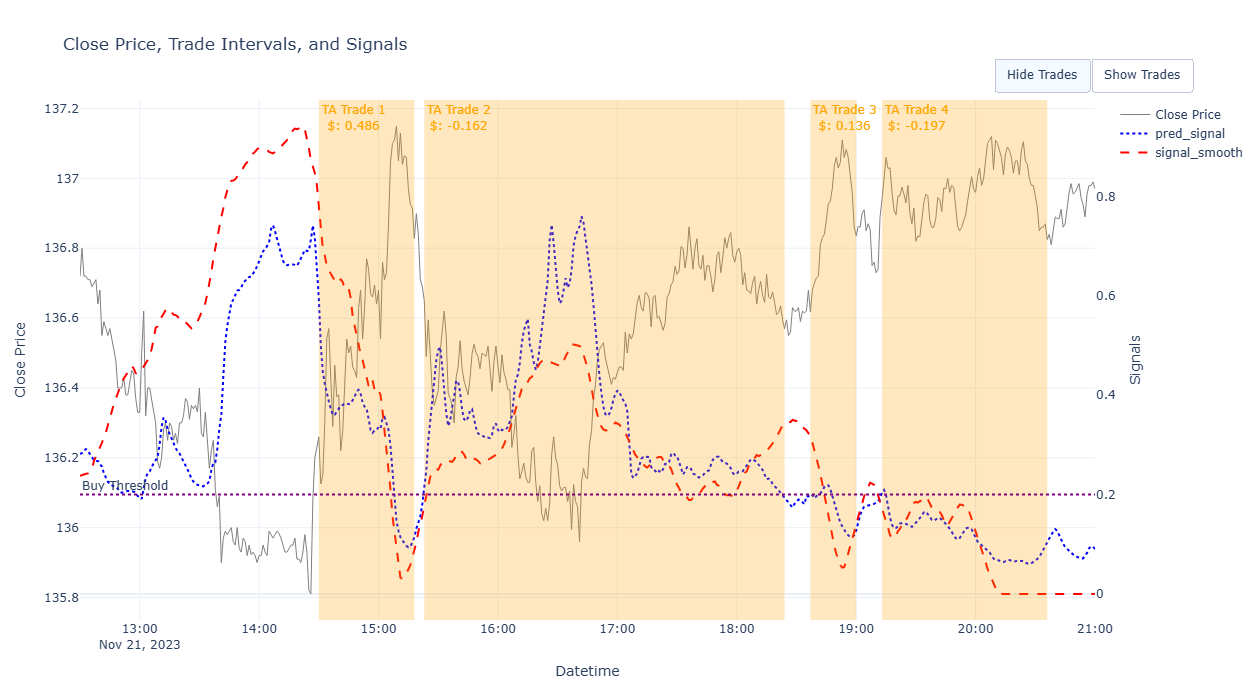


=== Performance for 2023-11-21 00:00:00 ===
Strategy Return ($): 0.263
Buy & Hold Return ($): 0.648
Trades Returns ($): [0.486, -0.162, 0.136, -0.197]


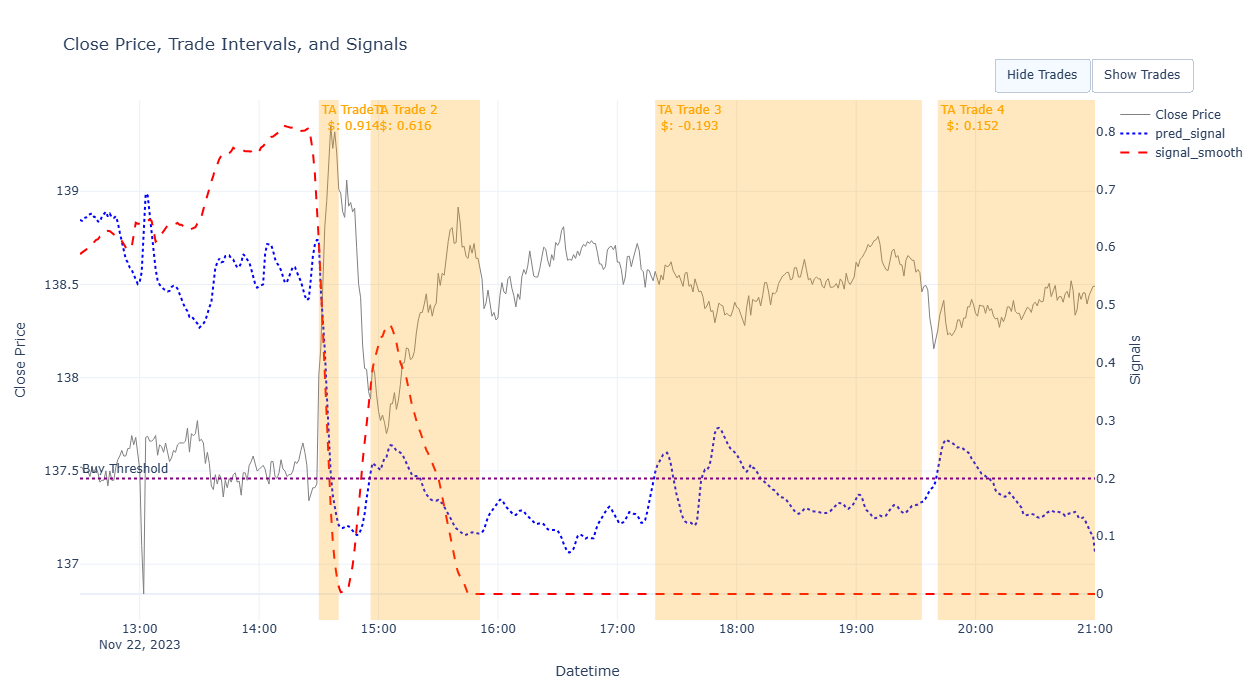


=== Performance for 2023-11-22 00:00:00 ===
Strategy Return ($): 1.489
Buy & Hold Return ($): 0.394
Trades Returns ($): [0.914, 0.616, -0.193, 0.152]


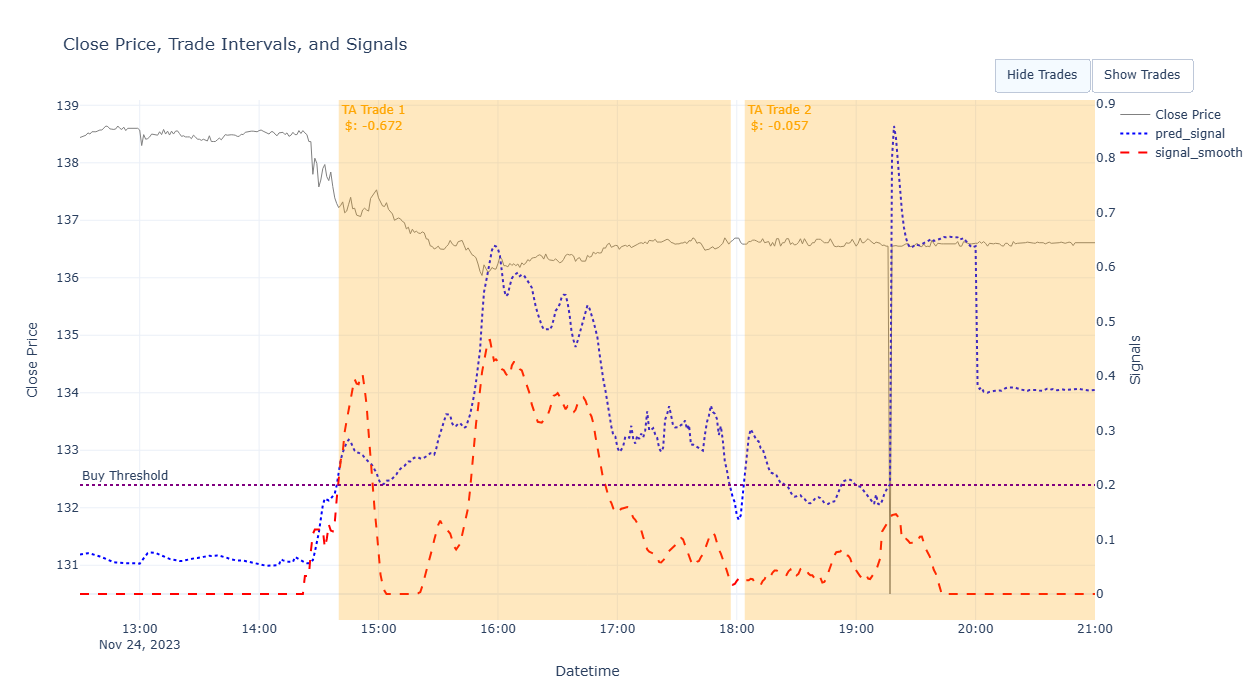


=== Performance for 2023-11-24 00:00:00 ===
Strategy Return ($): -0.729
Buy & Hold Return ($): -1.052
Trades Returns ($): [-0.672, -0.057]


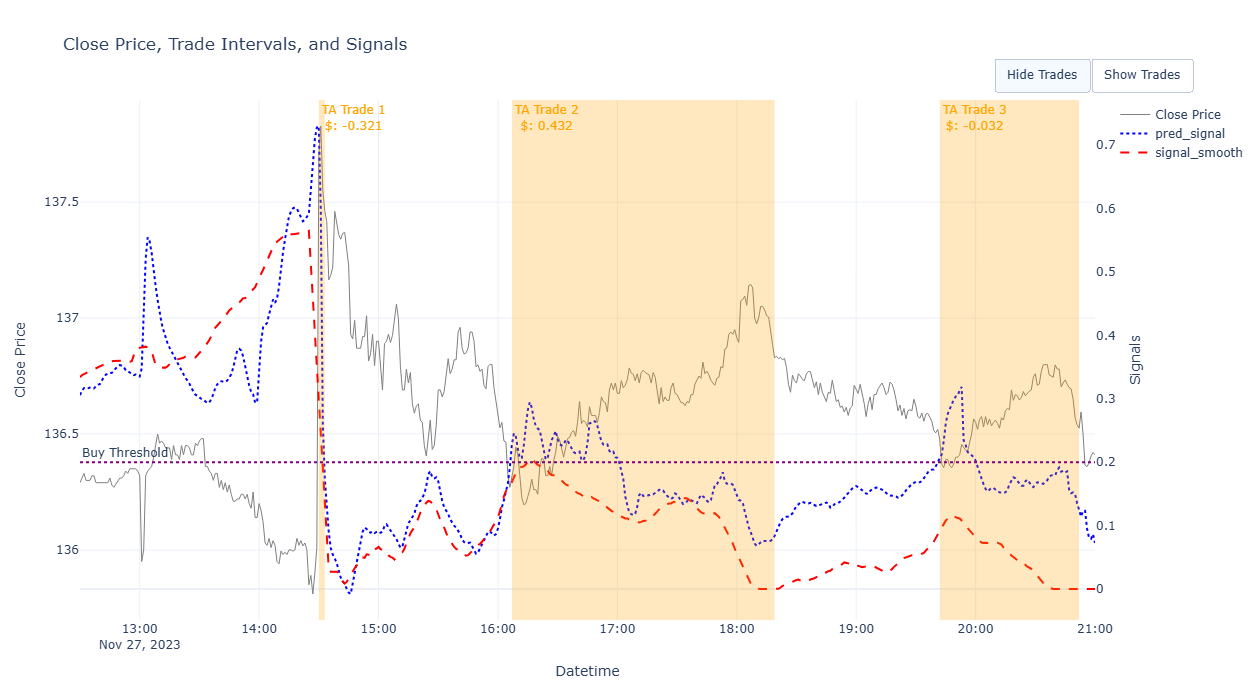


=== Performance for 2023-11-27 00:00:00 ===
Strategy Return ($): 0.079
Buy & Hold Return ($): -1.362
Trades Returns ($): [-0.321, 0.432, -0.032]


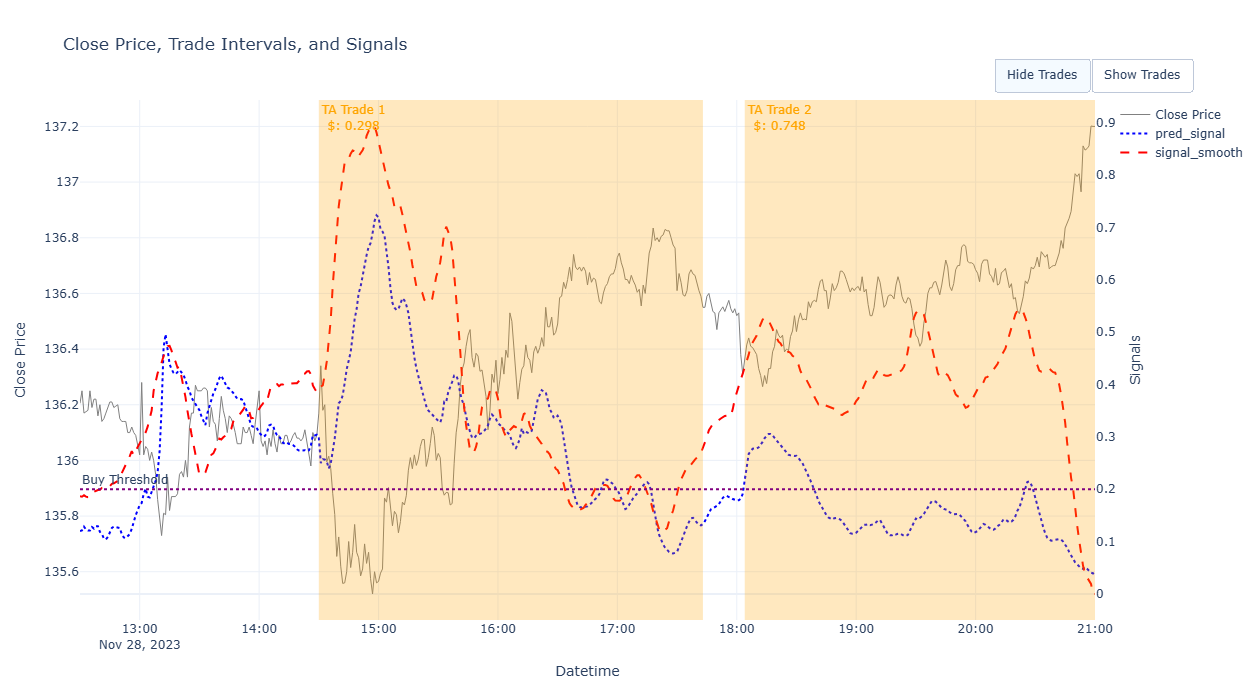


=== Performance for 2023-11-28 00:00:00 ===
Strategy Return ($): 1.046
Buy & Hold Return ($): 0.948
Trades Returns ($): [0.298, 0.748]


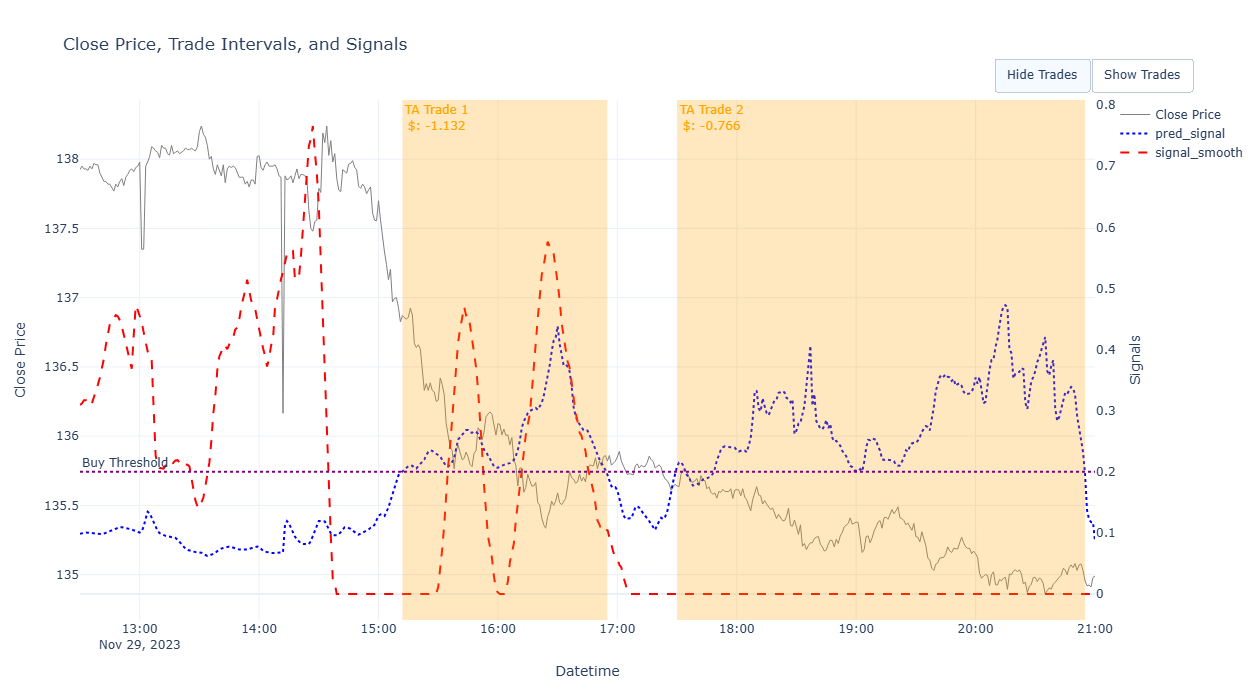


=== Performance for 2023-11-29 00:00:00 ===
Strategy Return ($): -1.898
Buy & Hold Return ($): -2.892
Trades Returns ($): [-1.132, -0.766]


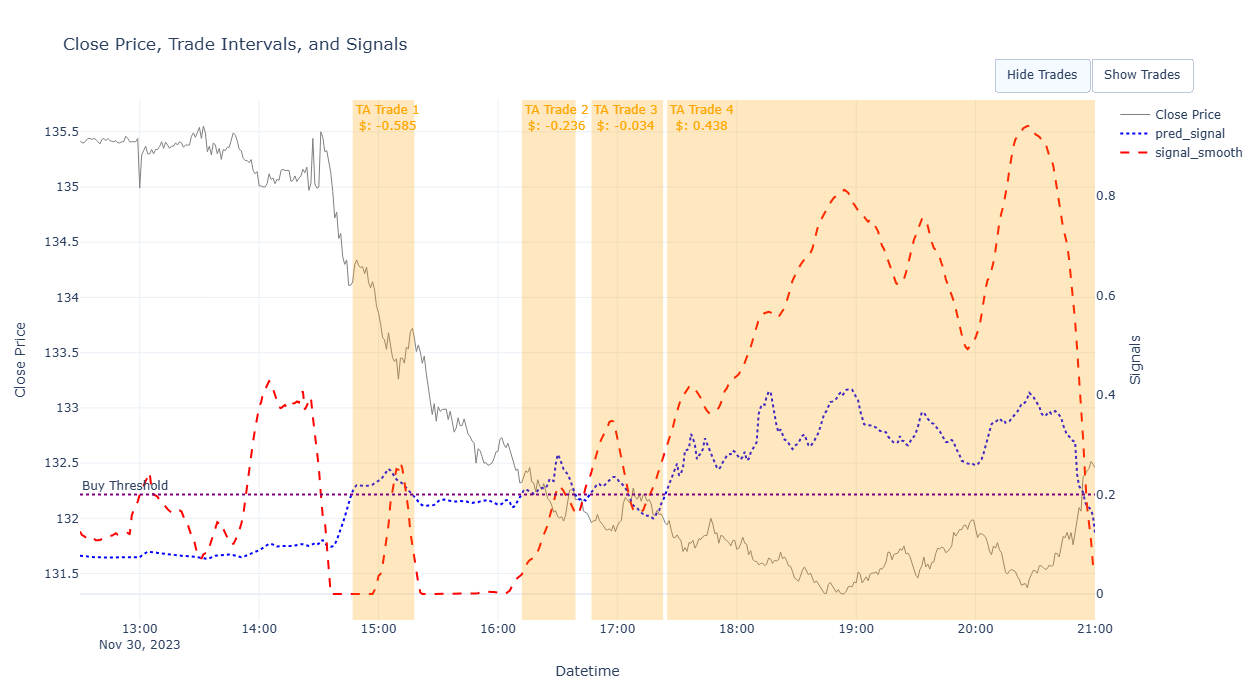


=== Performance for 2023-11-30 00:00:00 ===
Strategy Return ($): -0.386
Buy & Hold Return ($): -2.59
Trades Returns ($): [-0.585, -0.236, -0.034, 0.438]

=== Overall Summary (2023-11-01 → 2023-11-30) ===
Start date price: 2023-11-01 = 123.9172
  End date price:  2023-11-30 = 132.4189
One-time buy&hold gain: 8.502

{'Buy & Hold – each day ($)': 1.498,
 'Strategy Return ($)': 7.065,
 'Trades Returns ($)': '72 trades'}

=== Overall Summary (2023-10-12 → 2025-06-18) ===
Start date price: 2023-10-12 = 140.4855
  End date price:  2025-06-18 = 173.5576
One-time buy&hold gain: 33.072

{'Buy & Hold – each day ($)': -77.566,
 'Strategy Return ($)': 242.011,
 'Trades Returns ($)': '1578 trades'}


In [13]:

year, month = map(int, date_to_check.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_check}")
else:
    print(f"\nPlotting days in {date_to_check}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_man,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_with_preds[df_with_preds.index.to_period("M") == date_to_check]
monthly_summary = plots.aggregate_performance(performance_month, df_month)
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
overall_summary = plots.aggregate_performance(performance_all, df_with_preds)
pprint(overall_summary)
